In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
#import goproject.data
warnings.filterwarnings('ignore')

# Algunas predefiniciones

### Funcion para cargar mapa de C.A.B.A. y coordenadas de búsqueda

In [16]:
def plot_barrios(barrios_elegidos):
    bsas_map = gpd.read_file('../../gopa_data/barrios-ciudad')
    puntos = gpd.GeoDataFrame(ciudad,
                             geometry = gpd.points_from_xy(ciudad.search_longitude, ciudad.search_latitude))

    fig,ax = plt.subplots(figsize = (10,10))
    bsas_map.plot(ax=ax, color='lightgrey')
    puntos.plot(ax=ax, markersize=5, color='red')
    ax.set_xlim([-58.550, -58.325])
    ax.set_ylim([-34.700, -34.525])
    plt.show()

#  Cargamos dataset con las búsquedas

In [17]:
ciudad = pd.read_csv('ciudad_barrios.csv')
ciudad.head(5)

,Unnamed: 0,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,geometry,BARRIO
0,0,-58.441093,-34.587517,2021-03-06 03:40:51,2021-03-10 23:38:00,2021-03-10 10:38:00,searchInThisArea,IdVRqzjM1OQGXufqTmZIRv2CPhk1,POINT (-58.44109285622836 -34.58751745907739),CHACARITA
1,1,-58.448010,-34.584375,2021-03-29 00:28:46,2021-03-29 01:27:53,2021-03-29 00:27:53,google,NaN,POINT (-58.44800979999999 -34.58437500000001),CHACARITA
2,2,-58.451688,-34.585531,2021-03-16 23:17:52,2021-03-17 00:16:20,2021-03-16 23:16:20,searchInThisArea,NaN,POINT (-58.45168825238943 -34.58553119941662),CHACARITA
3,3,-58.447058,-34.587239,2020-11-16 18:51:29,2020-11-17 14:45:00,2020-11-17 06:45:00,this_area,unauthenticated,POINT (-58.44705808907748 -34.58723895499126),CHACARITA
4,4,-58.449097,-34.582538,2020-09-06 17:53:26,2020-09-06 19:00:22,2020-09-06 18:00:22,this_area,unauthenticated,POINT (-58.44909723848105 -34.58253791910862),CHACARITA


## Agregar algunos datos de horarios, dias, meses..

In [18]:
ciudad['timestamp'] = pd.to_datetime(ciudad['timestamp'])
ciudad['arrive'] = pd.to_datetime(ciudad['arrive'])
ciudad['leave'] = pd.to_datetime(ciudad['leave'])
ciudad['hour'] = ciudad['arrive'].dt.hour
ciudad['month_number'] = ciudad.arrive.dt.month
ciudad['month_name'] = ciudad.arrive.dt.month_name()
ciudad['weekday'] = ciudad.arrive.dt.weekday
ciudad['weekday_name'] = ciudad.arrive.dt.day_name()
ciudad.weekday_name = ciudad.weekday_name.map({'Monday': 'lunes', 'Tuesday': 'martes', 'Wednesday': 'miercoles',
 'Thursday': 'jueves', 'Saturday': 'viernes', 'Friday': 'sabado', 'Sunday': 'domingo'})

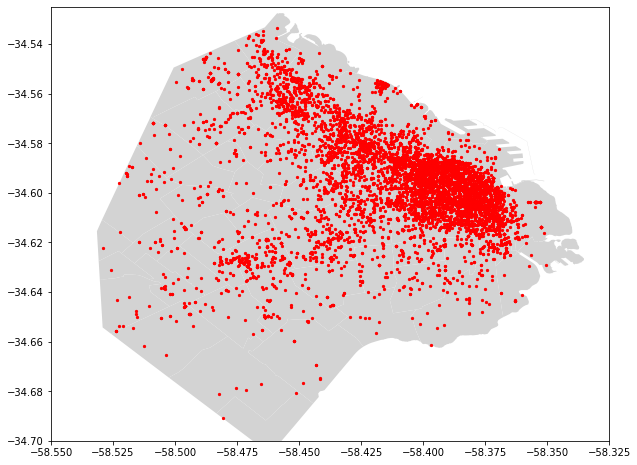

In [19]:
plot_barrios(ciudad)

In [20]:
ciudad.head(5)

,Unnamed: 0,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,geometry,BARRIO,hour,month_number,month_name,weekday,weekday_name
0,0,-58.441093,-34.587517,2021-03-06 03:40:51,2021-03-10 23:38:00,2021-03-10 10:38:00,searchInThisArea,IdVRqzjM1OQGXufqTmZIRv2CPhk1,POINT (-58.44109 -34.58752),CHACARITA,10,3,March,2,miercoles
1,1,-58.448010,-34.584375,2021-03-29 00:28:46,2021-03-29 01:27:53,2021-03-29 00:27:53,google,NaN,POINT (-58.44801 -34.58438),CHACARITA,0,3,March,0,lunes
2,2,-58.451688,-34.585531,2021-03-16 23:17:52,2021-03-17 00:16:20,2021-03-16 23:16:20,searchInThisArea,NaN,POINT (-58.45169 -34.58553),CHACARITA,23,3,March,1,martes
3,3,-58.447058,-34.587239,2020-11-16 18:51:29,2020-11-17 14:45:00,2020-11-17 06:45:00,this_area,unauthenticated,POINT (-58.44706 -34.58724),CHACARITA,6,11,November,1,martes
4,4,-58.449097,-34.582538,2020-09-06 17:53:26,2020-09-06 19:00:22,2020-09-06 18:00:22,this_area,unauthenticated,POINT (-58.44910 -34.58254),CHACARITA,18,9,September,6,domingo


# Analizamos la distribución de las busquedas de la ciudad entera

In [43]:
def distribucion_por_dia(df, dia= None):    
    if dia == None:
        return df.hour.value_counts(normalize=True).sort_index()
    
    elif dia.lower() in df.weekday_name.unique():
        cond = df['weekday_name'] == dia
        return df[cond].hour.value_counts(normalize=True).sort_index()
    
    else:
        print('error, día no encontrado')

def agregador(columna, n): #columna a dividir, número de partición
    columna = columna.sort_index()
    valores = [ ( f'{i}-{i+n}' , sum(columna[i:i+n]) ) for i in range(0,24,n) ]
    return pd.DataFrame(valores,columns=['horario','probabilidad']).set_index('horario')

def plotear_dia(df, dia, n):
    data = distribucion_por_dia(df, dia)
    agregado = agregador(data,n) 
    x = agregado.index
    y = agregado.probabilidad
    plt.figure(figsize=(15,6))
    plt.bar(x ,y*100, color = 'lightgreen')
    plt.grid(lw=0.4)
    plt.ylabel('probabilidad', fontdict = {'size':20})
    plt.xlabel('Franja Horaria', fontdict = {'size':20})
    
    if n == 1:
        plt.title(f'Distribución de probabilidad cada 1 hora el día {dia.upper()}:\nCABA', fontdict = {'size':25})
    else:
        plt.title(f'Distribución de probabilidad cada {n} horas el día {dia.upper()}:\nCABA', fontdict = {'size':25})

    
    font = {'family': 'monospace' ,  'color':  'white',
            'size': 10, 'horizontalalignment':'center'}
    for i in range(24//n):
        plt.text(i, #x
                 y[i]*50,
                 f'{round(y[i]*100, 2)}%', 
                 fontdict=font,
                 path_effects=[pe.withStroke(linewidth=2, foreground="black")])

    plt.show()


-----
## Distribución de busquedas en franjas horarias para distintos dias de la semana

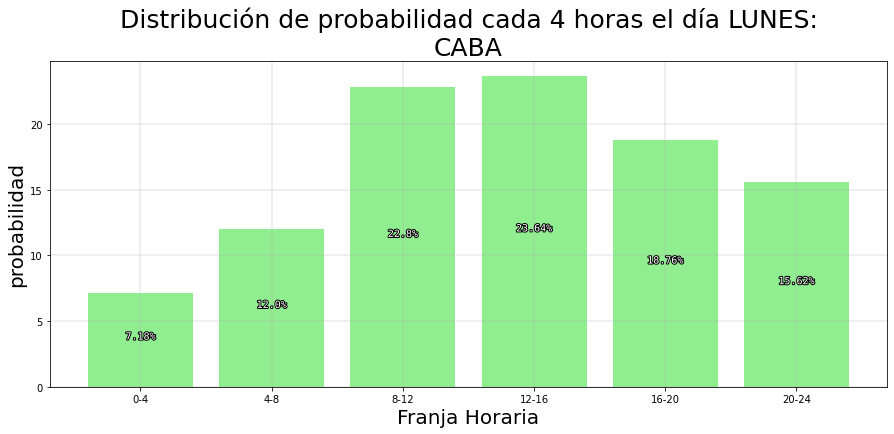

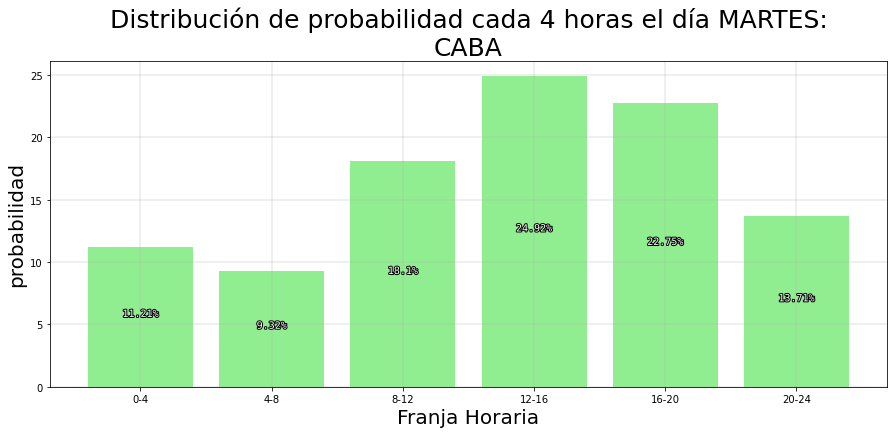

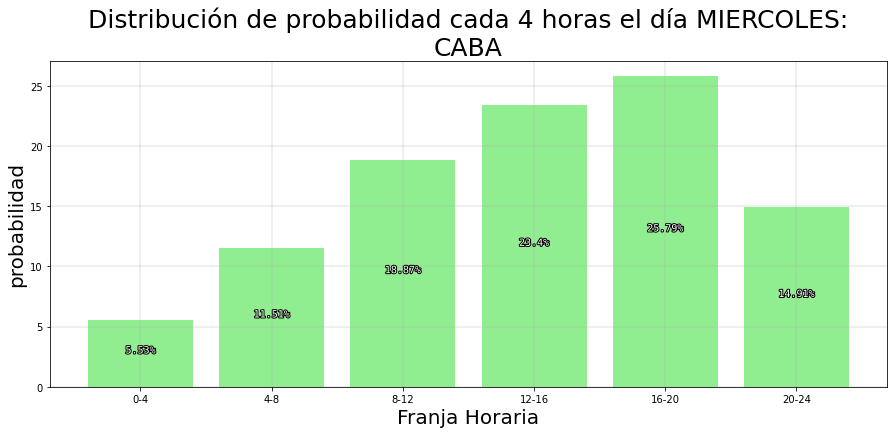

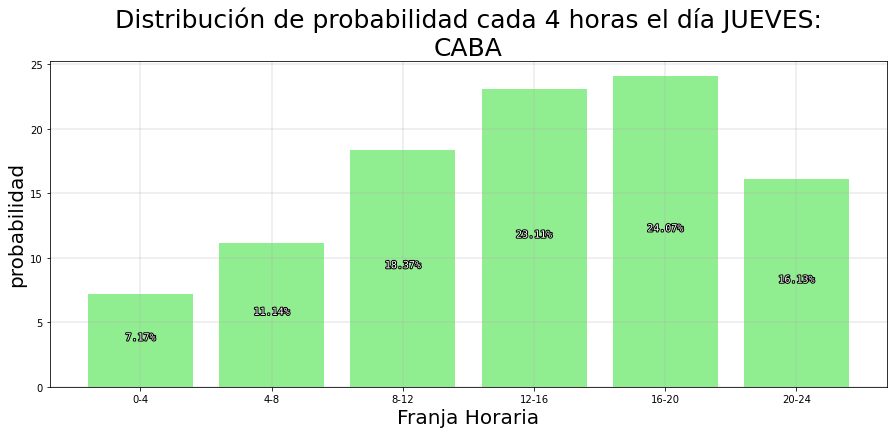

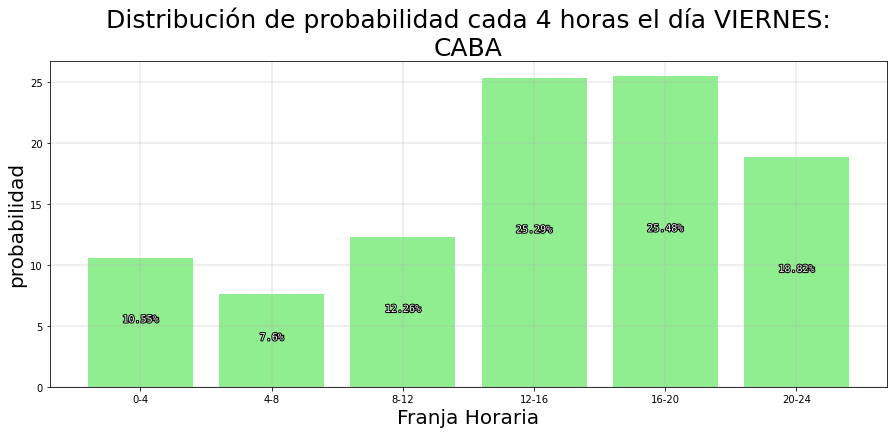

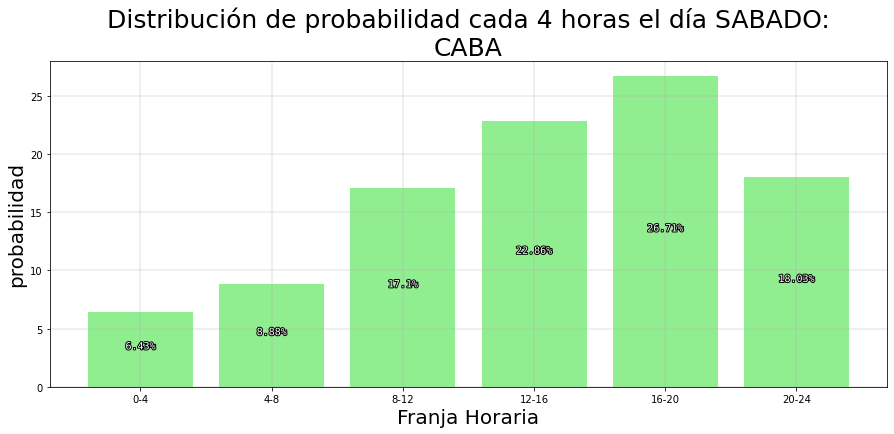

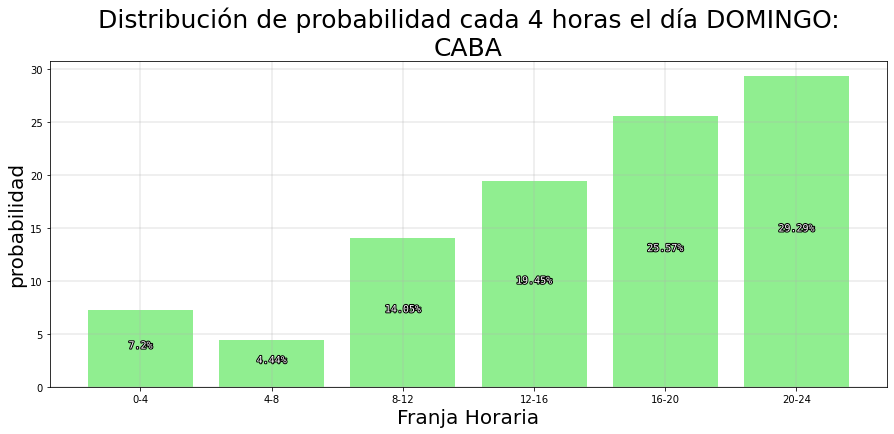

In [51]:
dias = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'domingo']

for dia_semana in dias :
    plotear_dia(ciudad, dia_semana ,4)    

<div class="alert alert-success" role="alert">
    <p><strong>Observaciones</strong></p>
    <p> Durante los días del fin de semana e incluso el jueves también aumentan notablemente  las búsquedas en el horario nocturno en comparación a los días de semana. </p>
    <p> </p>
</div>

## Toda la data en un dataframe

In [52]:
def frecuencias_df(df=None,n_agregacion=1,con_semana=False): #dataframe, número de agregación horaria, agregarle columna con total semanal o no

    dias_semana = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'domingo']

    if n_agregacion == 1:
        data = pd.DataFrame()
        for i in dias_semana[0:]:
            data[i] = distribucion_por_dia(df, i)
            data[i].replace(np.nan, 0, inplace=True)
        #data.columns = dias_semana
        if con_semana == True:
            data['semana'] = distribucion_por_dia(df)
    
    else:
        dias = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'domingo']
        data = pd.DataFrame(agregador(distribucion_por_dia(df, dias[0]) , n_agregacion))
        for i in dias_semana[1:]:
            data[i] = agregador(distribucion_por_dia(df, i) , n_agregacion)
        data.columns = dias
        if con_semana == True:
            data['semana'] = agregador(distribucion_por_dia(df) , n_agregacion)
        
    return data

### Formateo del dataframe

In [53]:
distribucion = frecuencias_df(ciudad, 1, con_semana=True)
distribucion.head()

,lunes,martes,miercoles,jueves,viernes,sabado,domingo,semana
0,0.019300,0.042539,0.010692,0.022407,0.052281,0.025182,0.032413,0.027568
1,0.026538,0.020257,0.023899,0.017926,0.014259,0.017893,0.012005,0.019824
2,0.010856,0.010128,0.013208,0.012164,0.013308,0.005302,0.009604,0.010635
3,0.015078,0.039163,0.007547,0.019206,0.025665,0.015905,0.018007,0.019721
4,0.014475,0.017556,0.035220,0.016645,0.019011,0.018555,0.003601,0.018895


In [54]:
distribucion = distribucion*100

In [55]:
def bar_formatter(df):
        return distribucion.style.format(formatter='{:.3f}%').bar(color = 'lightgreen', vmax=distribucion.semana.max()*1.5,
                                                                  vmin = 0, 
                                                                  align = 'left',
                                                                  subset = 'semana')\
    .background_gradient(cmap = 'BuPu', subset = df.columns[0:-1],
                        low = 0, high = 4) 
    
bar_formatter(distribucion)

,lunes,martes,miercoles,jueves,viernes,sabado,domingo,semana
0,1.930%,4.254%,1.069%,2.241%,5.228%,2.518%,3.241%,2.757%
1,2.654%,2.026%,2.390%,1.793%,1.426%,1.789%,1.200%,1.982%
2,1.086%,1.013%,1.321%,1.216%,1.331%,0.530%,0.960%,1.064%
3,1.508%,3.916%,0.755%,1.921%,2.567%,1.590%,1.801%,1.972%
4,1.448%,1.756%,3.522%,1.665%,1.901%,1.856%,0.360%,1.890%
5,2.895%,1.823%,2.642%,3.329%,1.711%,1.524%,0.240%,2.189%
6,4.765%,2.971%,3.333%,4.289%,2.376%,2.982%,2.641%,3.459%
7,2.895%,2.768%,2.013%,1.857%,1.616%,2.518%,1.200%,2.220%
8,3.559%,2.633%,1.509%,2.817%,3.327%,2.717%,2.161%,2.685%
9,3.920%,3.241%,2.642%,3.521%,3.707%,3.512%,3.721%,3.438%


#  Ahora ploteemos todo por cada barrio a cada hora!

In [56]:
conteo_barrios = ciudad[['weekday_name','hour','BARRIO']]

In [57]:
def barrios_dia(df,dia):
    
    '''separo el df para cada día'''
    
    return df[df['weekday_name'] == dia][['hour','BARRIO']]

#saco el df de número de casos por hora y barrio en un día. Exportable
def conteo_barrios_dia(df,dia,): #si n_barrios = 0, elijo toda la ciudad
    
    '''hago el df de numero de casos por hora y barrio en un día'''    
    
    df_dia = barrios_dia(df,dia)
    
    #filtro por el top número de barrios
    top_barrios = df_dia.BARRIO.value_counts().index
    
    conteobarrios = pd.DataFrame(df_dia[ df_dia['BARRIO']== top_barrios[0]  ].groupby('hour').count())
    conteobarrios.columns = [top_barrios[0]]
    
    for i in top_barrios[1:]:
        conteobarrios[i] = df_dia[ df_dia['BARRIO']== i  ].groupby('hour').count()
    
    conteobarrios['TOTAL'] = np.sum(conteobarrios,axis = 1)
    conteobarrios.replace(np.nan, 0,inplace=True)
    
    return conteobarrios.astype('int64')

def conteo_barrios_frecuencia(df):
    '''transformo el número de casos en frecuencias con respecto al TOTAL global
    Devuelve el df con el número total de barrios'''
    
    for i in df.columns[:-1]:
        df[i] = df.apply(lambda x : x[i] / x.TOTAL, axis  = 1)
    df.drop(columns = 'TOTAL', inplace = True)
    return df

In [93]:
cont_1 = conteo_barrios_dia(ciudad, 'martes') #creo un df con los casos de un día y todos los barios
cont_2 = conteo_barrios_frecuencia(cont_1)
cont_2

,RECOLETA,SAN NICOLAS,PALERMO,BALVANERA,RETIRO,MONSERRAT,BELGRANO,FLORES,CABALLITO,NUÃEZ,...,PARQUE CHACABUCO,NUEVA POMPEYA,LINIERS,PARQUE PATRICIOS,COGHLAN,VELEZ SARSFIELD,MATADEROS,PARQUE AVELLANEDA,BOEDO,VILLA LURO
hour,,,,,,,,,,,,,,,,,,,,,
0,0.285714,0.126984,0.222222,0.111111,0.000000,0.000000,0.000000,0.031746,0.031746,0.047619,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.300000,0.133333,0.066667,0.033333,0.033333,0.000000,0.033333,0.000000,0.033333,0.133333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.333333,0.200000,0.400000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.153846,0.115385,0.192308,0.153846,0.038462,0.076923,0.000000,0.000000,0.076923,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.111111,0.148148,0.296296,0.148148,0.074074,0.037037,0.000000,0.037037,0.000000,0.074074,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.045455,0.318182,0.022727,0.136364,0.181818,0.000000,0.068182,0.045455,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.097561,0.073171,0.146341,0.073171,0.292683,0.048780,0.000000,0.000000,0.048780,0.024390,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.076923,0.179487,0.205128,0.205128,0.076923,0.102564,0.000000,0.102564,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.229167,0.145833,0.166667,0.000000,0.104167,0.020833,0.020833,0.000000,0.041667,0.000000,...,0.020833,0.020833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020833,0.000000


In [90]:
def plot_frecuencias_barrios(df, dia, n_top_barrios = 3 ):
    '''ploteo un gráfico de barras parcial'''

    # saco una lista de los barrios con más ocurrencias y selecciono el top n
    top_barrios = df.BARRIO.value_counts().index[:n_top_barrios] 

    cont_1 = conteo_barrios_dia(df, dia) #creo un df con los casos de un día y todos los barios
    cont_2 = conteo_barrios_frecuencia(cont_1) #calculo un df contando cada caso por hora para cada barrio, separado en cada columna
    top_df= cont_2[top_barrios] #separo por los barrios de mayores casos


    df_plot = top_df*100 #multiplico todo por 100 para tener porcentajes legibles para les humanes normales

    '''creo el gráfic!'''
    fig, axes = plt.subplots(nrows=1, figsize=(18, 8) )
    pl = df_plot.plot(kind = 'bar',stacked = True ,  ax=axes)
        
    '''formateo de las etiquetas! cuidado!'''
    font = {'family': 'monospace' ,  'color':  'black',
                'size': 10, 'horizontalalignment':'center'}
    for bar in pl.patches:
        x = bar.get_x() + bar.get_width() / 2
        y =  bar.get_y() + bar.get_height()/2  #+ y_offset
        etiqueta = f'{round(bar.get_height(),1) }%'
        pl.text(
            x, y,  # las posiciones en cada punto
            s = etiqueta, #el número a poner en cada punto

          fontdict = font,
          #path_effects=[pe.withStroke(linewidth=2, foreground="black")]
        )

    plt.title(f'Porcentaje de ocurrencias para los {n_top_barrios} barrios con más búsquedas\nDía {dia.upper()}', size = 20)
    pl.set_ylabel('porcentaje de ocurrencias', size = 15)
    pl.set_xlabel('hora del día', size = 15)
    pl.spines["top"].set_visible(False)
    pl.spines["right"].set_visible(False)
    pl.spines["left"].set_visible(False)
    #pl.set_facecolor("#FBF6D9")

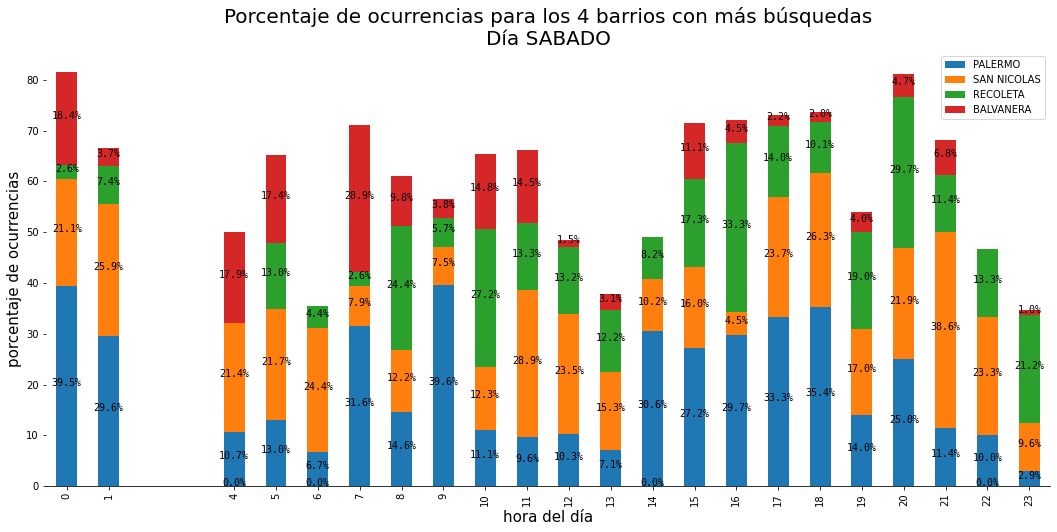

In [94]:
plot_frecuencias_barrios(ciudad, 'sabado',4)

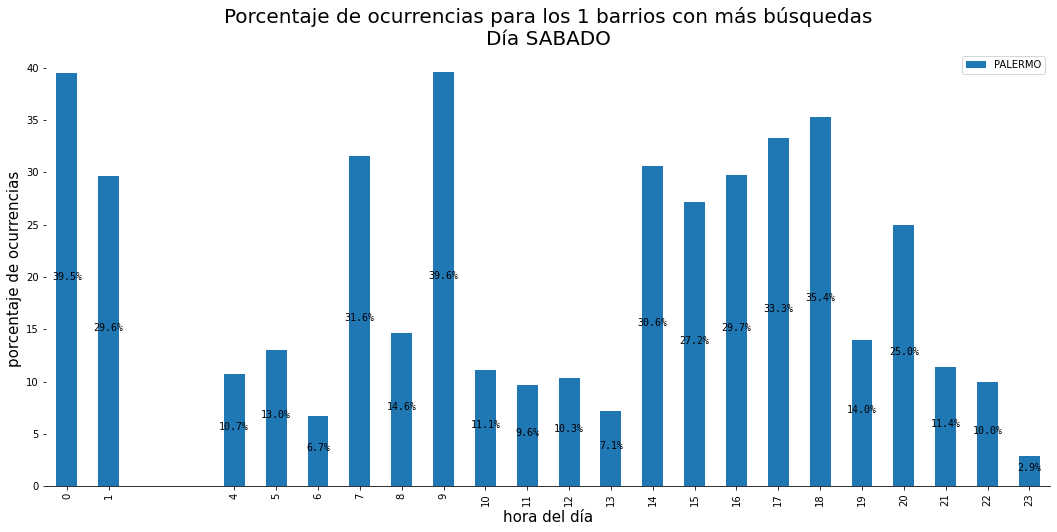

In [92]:
plot_frecuencias_barrios(ciudad, 'sabado',1)

<div class="alert alert-success" role="alert">
    <p><strong>Observaciones</strong></p>
    <p> Los barrios de Palermo, San Nicolas, Recoleta, Balvanera y Retiro son los mas buscados para hacer reservas cualquier dia de la semana.
    <p> </p>

## Los 7 dias de la semana para los 3 barrios mas buscados de la ciudad

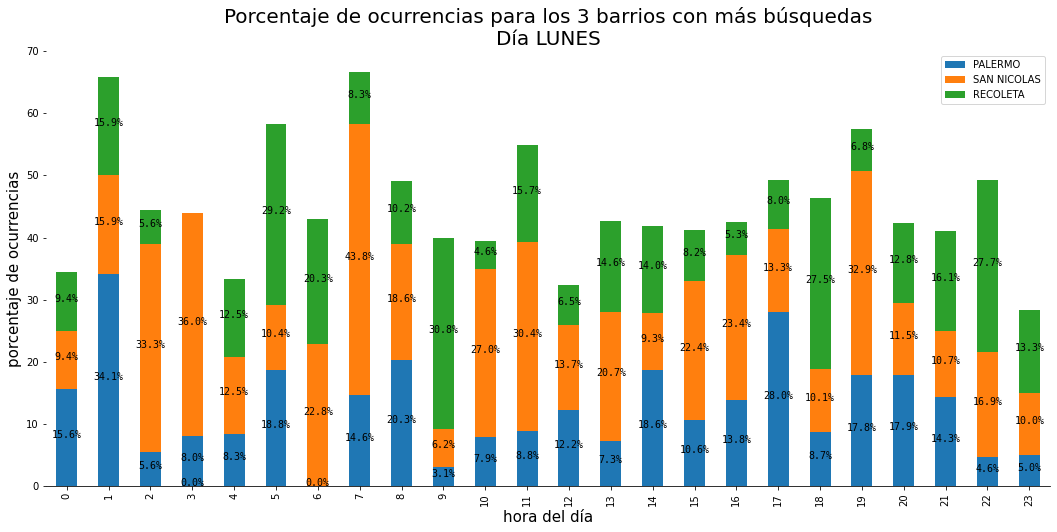

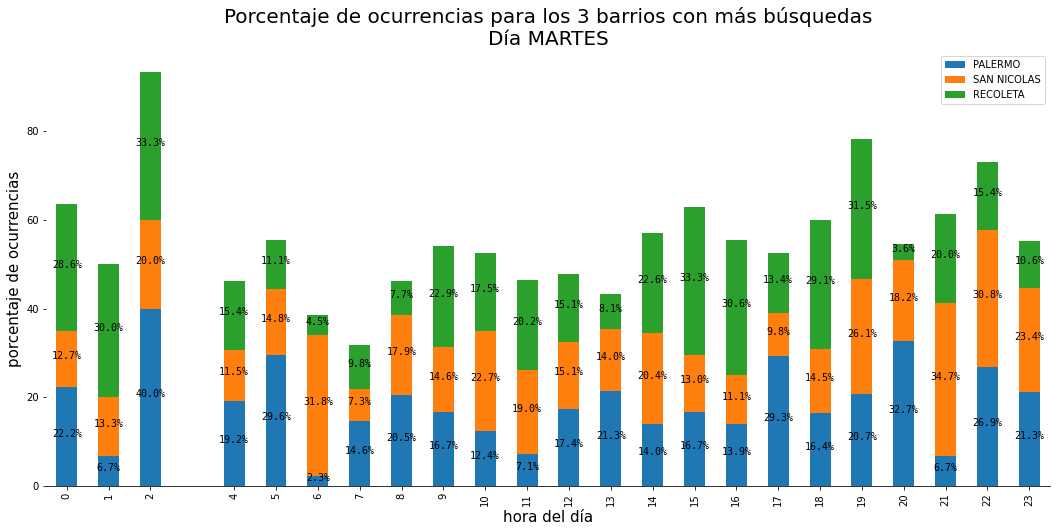

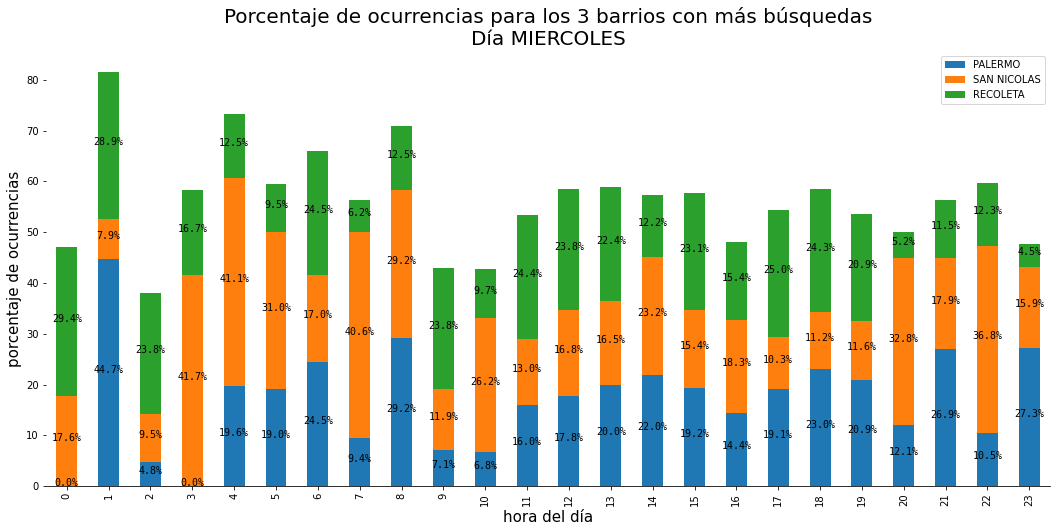

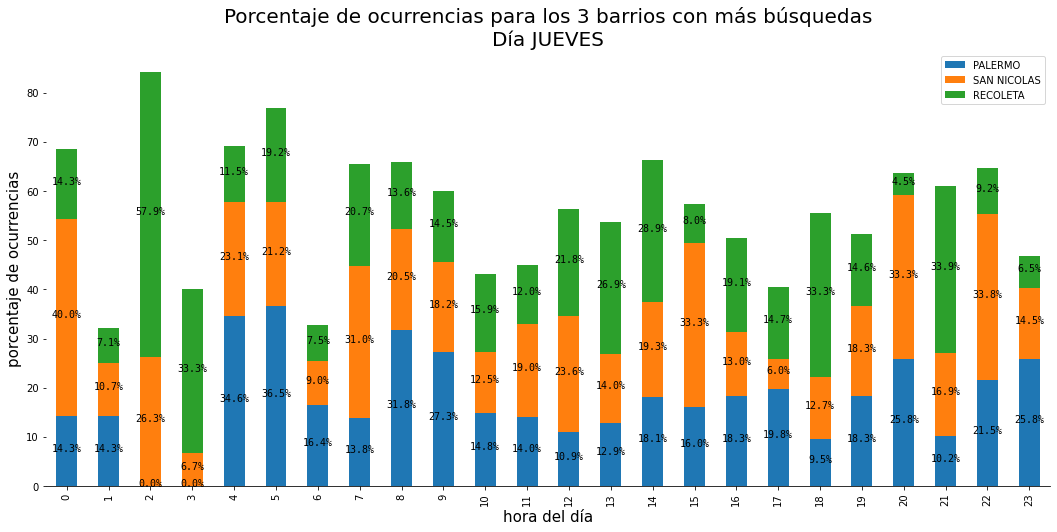

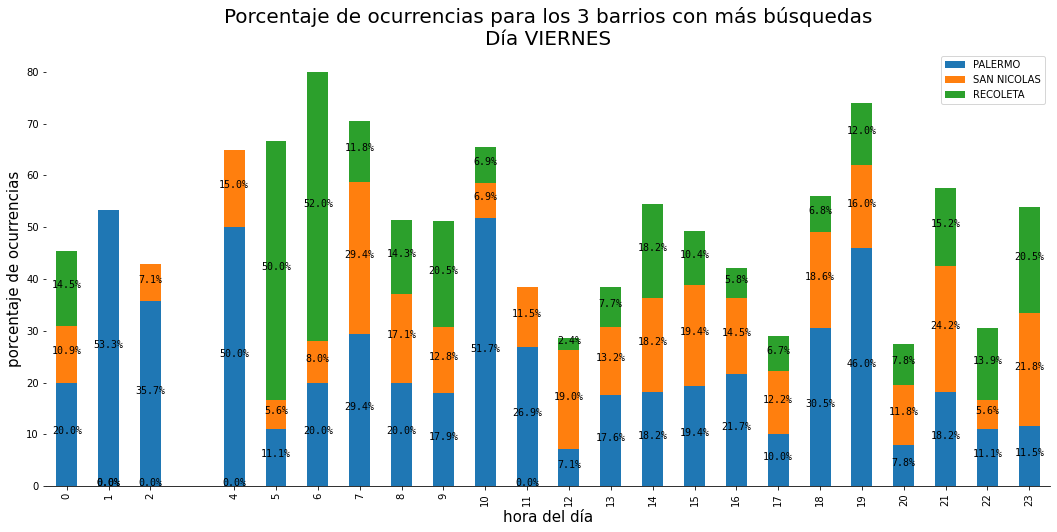

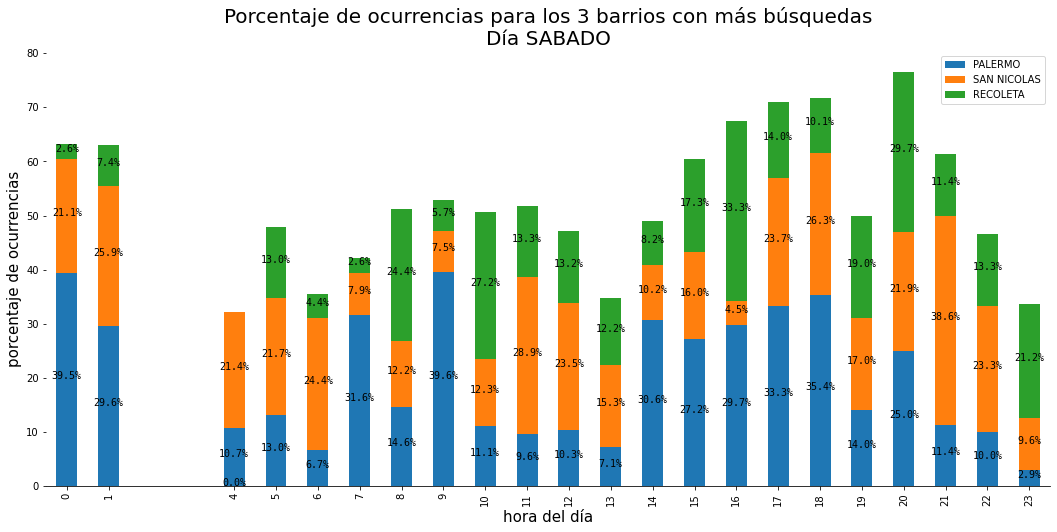

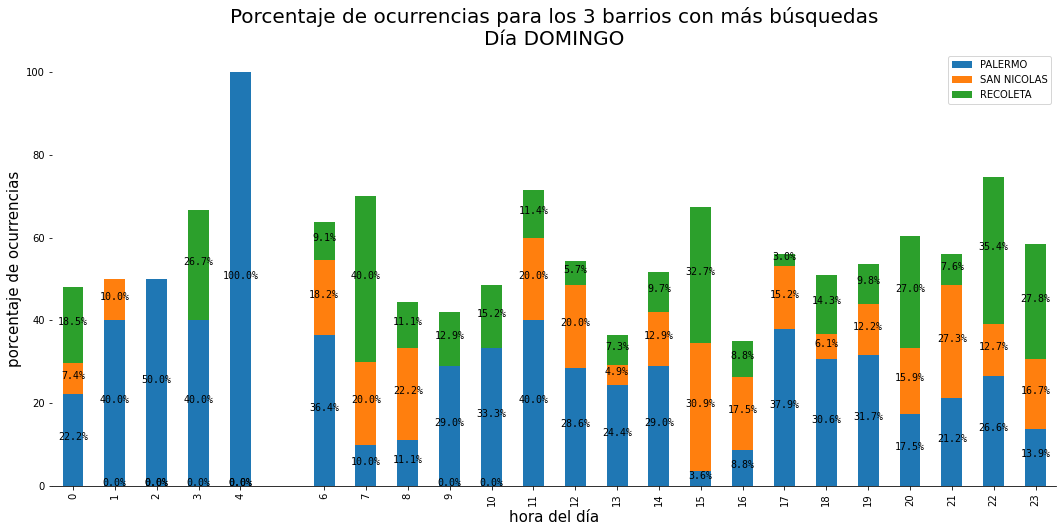

In [95]:
#para cada día:
def plot_frecuencias_barrios_semana(df, top_barrios=3):
    dias_semana = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'domingo']
    for i in dias_semana:
        plot_frecuencias_barrios(df,i,top_barrios)
        
plot_frecuencias_barrios_semana(ciudad)

In [17]:
def exportar_df_barrios(df,dia,  n_top_barrios= 0):
    if n_top_barrios == 0:
        top_barrios = df.BARRIO.value_counts().index 
        cont_1 = conteo_barrios_dia(df, 'lunes') #creo un df con los casos de un día y todos los barios
        cont_2 = conteo_barrios_frecuencia(cont_1) #calculo un df contando cada caso por hora para cada barrio, separado en cada columna
        return  cont_2.to_csv(f'frecuencia_barrios_{dia}.csv')
    else:
        top_barrios = df.BARRIO.value_counts().index[:n_top_barrios] 
        cont_1 = conteo_barrios_dia(df, 'lunes') #creo un df con los casos de un día y todos los barios
        cont_2 = conteo_barrios_frecuencia(cont_1) #calculo un df contando cada caso por hora para cada barrio, separado en cada columna
        top_df= cont_2[top_barrios]
        return top_df.to_csv(f'frecuencia_barrios_{dia}_{n_top_barrios}topbarrios.csv')

In [18]:
#exportar_df_barrios(ciudad,'lunes', 3)